## Client Generation

In [116]:
from neumai.Client.NeumClient import NeumClient
import pandas as pd
import os

client = NeumClient(api_key=os.environ['NEUM_API_KEY'])

## Helper functions

In [72]:
from datetime import datetime, timezone

def calculate_time_differences_unix(unix_timestamp):
    now = datetime.now(timezone.utc)
    given_time = datetime.fromtimestamp(unix_timestamp, timezone.utc)

    diff = now - given_time
    diff_in_seconds = diff.total_seconds()
    diff_in_minutes = divmod(diff_in_seconds, 60)[0]
    diff_in_hours = divmod(diff_in_minutes, 60)[0]
    diff_in_days = divmod(diff_in_hours, 24)[0]

    date_str = given_time.strftime('%Y-%m-%d')

    if diff_in_seconds < 60:
        return f"{int(diff_in_seconds)} secs ago"
    elif diff_in_minutes < 60:
        return f"{int(diff_in_minutes)} mins ago"
    elif diff_in_hours < 24:
        return f"{int(diff_in_hours)} hours ago"
    elif diff_in_days < 15:
        return f"{int(diff_in_days)} days ago"
    else:
        return date_str


In [46]:
from datetime import datetime, timezone

def calculate_time_differences_iso(iso_timestamp):
    now = datetime.now(timezone.utc)
    # Parse the ISO 8601 formatted string
    given_time = datetime.fromisoformat(iso_timestamp).replace(tzinfo=timezone.utc)

    diff = now - given_time
    diff_in_seconds = diff.total_seconds()
    diff_in_minutes = divmod(diff_in_seconds, 60)[0]
    diff_in_hours = divmod(diff_in_minutes, 60)[0]
    diff_in_days = divmod(diff_in_hours, 24)[0]

    date_str = given_time.strftime('%Y-%m-%d')

    if diff_in_seconds < 60:
        return f"{int(diff_in_seconds)} secs ago"
    elif diff_in_minutes < 60:
        return f"{int(diff_in_minutes)} mins ago"
    elif diff_in_hours < 24:
        return f"{int(diff_in_hours)} hours ago"
    elif diff_in_days < 15:
        return f"{int(diff_in_days)} days ago"
    else:
        return date_str

## Pipelines data -> My Pipelines

API to see Number of file collections (pipelines) created

In [99]:
results = client.get_pipelines()['pipelines_v2']

In [100]:
df = pd.DataFrame(results)
df = df[df["is_deleted"] != True]
df = df.drop(columns=["sources", "embed", "sink", "trigger_schedule", "latest_run", "available_metadata", "is_deleted", "owner"])
df['created'] = df['created'].apply(calculate_time_differences_unix)
display(df)

,id,name,created,updated
0,3bd8328a-13d6-4f28-8777-4193004b3980,Secrets,2023-11-20,None
1,689cf2f9-6cc6-470c-8c5c-1c37f9a823c7,None,2023-11-20,None
2,1c9bafba-913e-40f4-bd91-86cbd8ac9d46,Ice cream FAQs,2023-11-20,None
3,e8cf7c29-57f4-416c-a66e-212f451ebf47,None,2023-11-20,None
4,3f376eff-5d28-4bdc-8c76-7ce63e9b0987,None,8 days ago,None
5,590a6e0d-5444-44d2-8efc-1aadffb72e62,hello,1 hours ago,None


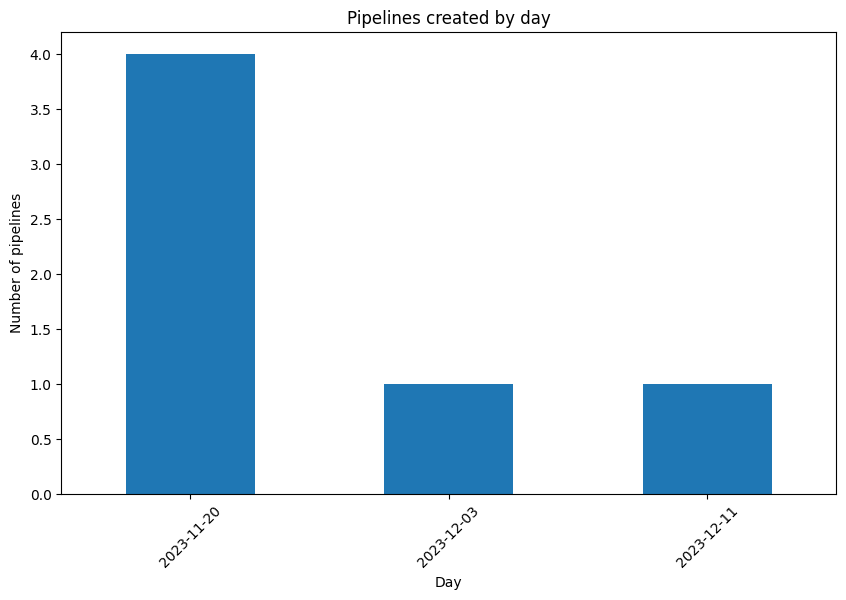

In [101]:
import matplotlib.pyplot as plt
df = pd.DataFrame(results)
df = df[df["is_deleted"] != True]
df = df.drop(columns=["sources", "embed", "sink", "trigger_schedule", "latest_run", "available_metadata", "is_deleted", "owner"])
df['created'] = pd.to_datetime(df['created'], unit='s')
df_grouped = df.groupby(df['created'].dt.date).size()

plt.figure(figsize=(10, 6))
df_grouped.plot(kind='bar')
plt.xlabel('Day')
plt.ylabel('Number of pipelines')
plt.title('Pipelines created by day')
plt.xticks(rotation=45)
plt.show()

## Files data -> My Files

API to see Number of files synchronized / syncing / failed for each collection

In [102]:
files = client.get_files(pipeline_id="590a6e0d-5444-44d2-8efc-1aadffb72e62")['files']

In [103]:
df_files = pd.DataFrame(files)
df_files = df_files.drop(columns=["metadata", "pipeline_id", "pipeline_run_id"])
df_files['created_time'] = df_files['created_time'].apply(calculate_time_differences_iso)
df_files['modified_time'] = df_files['modified_time'].apply(calculate_time_differences_iso)
display(df_files)

,id,name,created_time,modified_time,status
0,590a6e0d-5444-44d2-8efc-1aadffb72e62_Fabulous ...,Fabulous Frozen Delights FAQ/Fabulous Frozen D...,1 hours ago,1 hours ago,synced
1,590a6e0d-5444-44d2-8efc-1aadffb72e62_Fabulous ...,Fabulous Frozen Delights FAQ/Fabulous Frozen D...,1 hours ago,1 hours ago,synced
2,590a6e0d-5444-44d2-8efc-1aadffb72e62_Fabulous ...,Fabulous Frozen Delights FAQ/Fabulous Frozen D...,1 hours ago,1 hours ago,synced


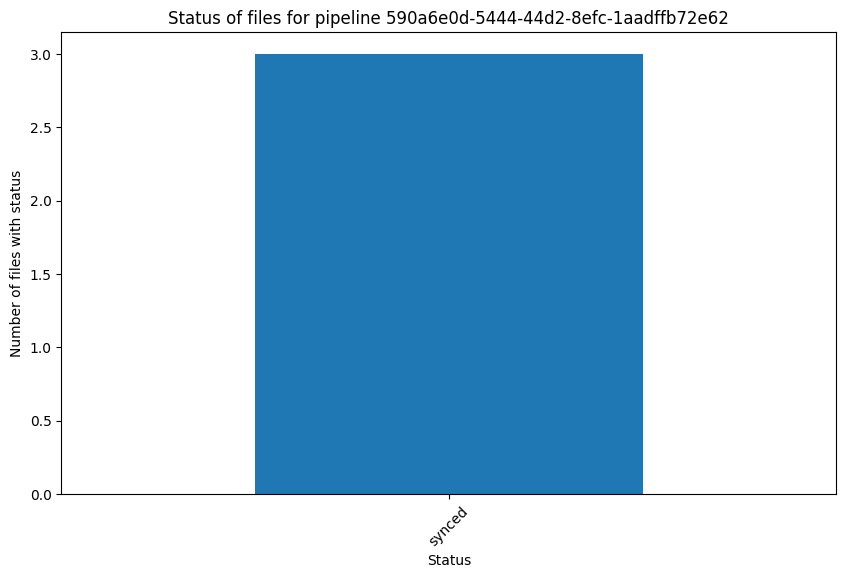

In [104]:
df_files_status_grouped = df_files.groupby(df_files['status']).size()

plt.figure(figsize=(10, 6))
df_files_status_grouped.plot(kind='bar')
plt.xlabel('Status')
plt.ylabel('Number of files with status')
plt.title(f'Status of files for pipeline {"590a6e0d-5444-44d2-8efc-1aadffb72e62"}')
plt.xticks(rotation=45)
plt.show()

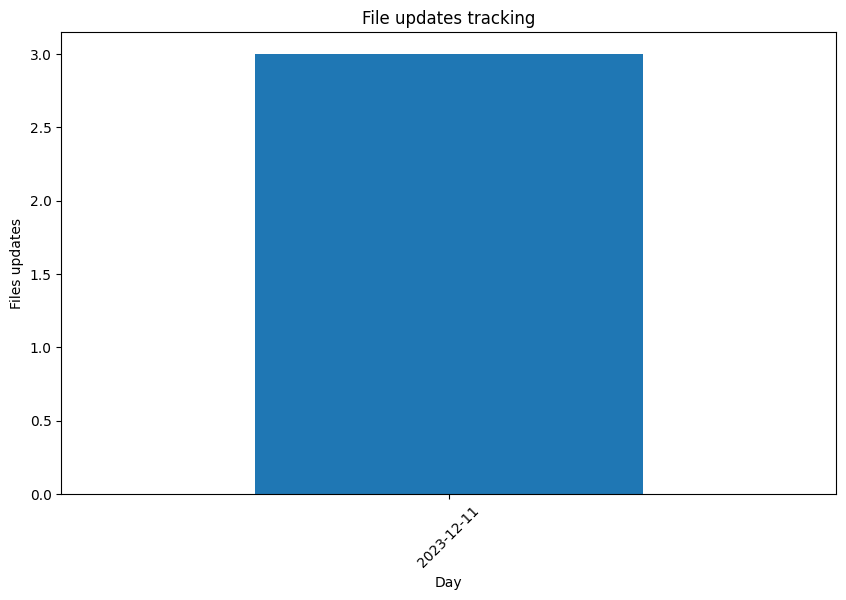

In [105]:
import matplotlib.pyplot as plt
df_files_graph = pd.DataFrame(files)
df_files_graph['modified_time'] = pd.to_datetime(df_files_graph['modified_time'])
df_files_grouped = df_files_graph.groupby(df_files_graph['modified_time'].dt.date).size()

plt.figure(figsize=(10, 6))
df_files_grouped.plot(kind='bar')
plt.xlabel('Day')
plt.ylabel('Files updates')
plt.title('File updates tracking')
plt.xticks(rotation=45)
plt.show()

## Search results by pipeline

API to see Number of times a file collection has been searched over time

In [106]:
retrievals = client.get_retrievals_by_pipeline_id(pipeline_id="590a6e0d-5444-44d2-8efc-1aadffb72e62")

In [107]:
df_retrievals = pd.DataFrame(retrievals)
df_retrievals = df_retrievals.drop(columns=["pipeline_id", "results", "status"])
df_retrievals['timestamp'] = df_retrievals['timestamp'].apply(calculate_time_differences_unix)
# df_retrievals['modified_time'] = df_retrievals['modified_time'].apply(calculate_time_differences_iso)
display(df_retrievals)

,id,requested_by,files,query,timestamp
0,7756f61b-bb76-4d73-89f3-ab7501fd8cef,Test David,"[File not defined, File not defined, 590a6e0d-...",What are your most popular ice cream flavors?,1 hours ago
1,241c85a9-a3ad-42d7-beae-994f05f162d9,Test David,"[File not defined, File not defined, File not ...",Do you offer any unique or seasonal flavors?,1 hours ago
2,ffd8a0d9-72d8-4291-a5b4-a8809dc1aba8,Test David,"[File not defined, 590a6e0d-5444-44d2-8efc-1aa...",Are there any vegan or lactose-free options av...,1 hours ago
3,0ffd1bc1-f782-42eb-9445-935e81aa4ddd,Test David,"[File not defined, 590a6e0d-5444-44d2-8efc-1aa...",Where do you source your ingredients from?,1 hours ago
4,c0eadb63-6890-4603-b8c8-c50b19597815,Test David,"[File not defined, File not defined, File not ...",Do you have any signature sundaes or special c...,1 hours ago
5,3ec7ac05-d0fd-41db-98c4-2edc9bf7dc6f,Test David,"[File not defined, File not defined, 590a6e0d-...",Can I sample a flavor before making a purchase?,1 hours ago
6,d4ba3ade-b0d5-4ca4-aa05-3e9e515c824b,Test David,"[File not defined, File not defined, 590a6e0d-...",Do you offer any discounts or loyalty programs?,1 hours ago
7,dba96927-f48d-4b8c-8fe4-9d48853b5155,Test David,"[File not defined, File not defined, File not ...",Are there any allergen-friendly options availa...,1 hours ago
8,26ee9691-bd64-42a9-bea8-81fcb57645c7,Test David,"[File not defined, 590a6e0d-5444-44d2-8efc-1aa...",Can I order ice cream cakes or large quantitie...,1 hours ago
9,bf23c3e4-2a00-4735-ae52-a310594f9ba2,Test David,"[File not defined, File not defined, File not ...",What are your hours of operation and location?,1 hours ago


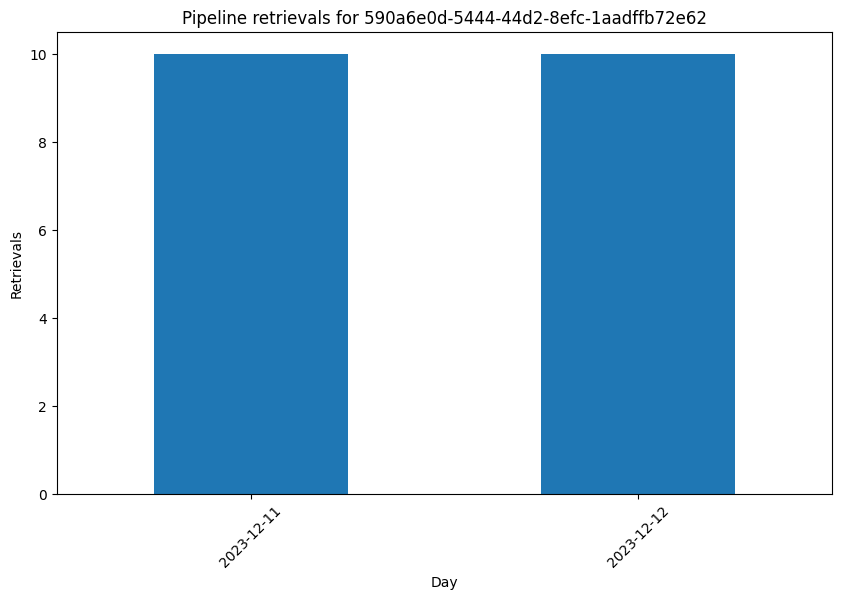

In [108]:
df_retrievals_graph = pd.DataFrame(retrievals)
df_retrievals_graph = df_retrievals_graph.drop(columns=["pipeline_id", "results", "status"])
df_retrievals_graph['timestamp'] = pd.to_datetime(df_retrievals_graph['timestamp'], unit='s')  # or 'ms' for milliseconds
df_retrievals_grouped = df_retrievals_graph.groupby(df_retrievals_graph['timestamp'].dt.date).size()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
df_retrievals_grouped.plot(kind='bar')
plt.xlabel('Day')
plt.ylabel('Retrievals')
plt.title(f'Pipeline retrievals for {"590a6e0d-5444-44d2-8efc-1aadffb72e62"}')
plt.xticks(rotation=45)
plt.show()

### Number of retrievals for a given file

API to see Number of times a file in a file collection has been searched over time

In [109]:
df_retrievals_exploded = df_retrievals.explode('files')
df_retrievals_exploded = df_retrievals_exploded[df_retrievals_exploded["files"] != 'File not defined']
display(df_retrievals_exploded)

,id,requested_by,files,query,timestamp
0,7756f61b-bb76-4d73-89f3-ab7501fd8cef,Test David,590a6e0d-5444-44d2-8efc-1aadffb72e62_Fabulous ...,What are your most popular ice cream flavors?,1 hours ago
2,ffd8a0d9-72d8-4291-a5b4-a8809dc1aba8,Test David,590a6e0d-5444-44d2-8efc-1aadffb72e62_Fabulous ...,Are there any vegan or lactose-free options av...,1 hours ago
3,0ffd1bc1-f782-42eb-9445-935e81aa4ddd,Test David,590a6e0d-5444-44d2-8efc-1aadffb72e62_Fabulous ...,Where do you source your ingredients from?,1 hours ago
5,3ec7ac05-d0fd-41db-98c4-2edc9bf7dc6f,Test David,590a6e0d-5444-44d2-8efc-1aadffb72e62_Fabulous ...,Can I sample a flavor before making a purchase?,1 hours ago
6,d4ba3ade-b0d5-4ca4-aa05-3e9e515c824b,Test David,590a6e0d-5444-44d2-8efc-1aadffb72e62_Fabulous ...,Do you offer any discounts or loyalty programs?,1 hours ago
8,26ee9691-bd64-42a9-bea8-81fcb57645c7,Test David,590a6e0d-5444-44d2-8efc-1aadffb72e62_Fabulous ...,Can I order ice cream cakes or large quantitie...,1 hours ago
10,5ead72a3-4ca0-45a3-8d3e-0f6420607632,Test Kevin,590a6e0d-5444-44d2-8efc-1aadffb72e62_Fabulous ...,What are the top 5 most popular flavors at the...,49 secs ago
11,8bd09172-b88c-4819-9ea4-3aaacca00a80,Test Kevin,590a6e0d-5444-44d2-8efc-1aadffb72e62_Fabulous ...,How many different toppings does the ice cream...,46 secs ago
12,a24599ca-59ab-4960-833a-53d504f3b9a8,Test Kevin,590a6e0d-5444-44d2-8efc-1aadffb72e62_Fabulous ...,What are the shop's hours of operation?,45 secs ago
13,8c532f13-a97b-4284-be29-39aa5af96eeb,Test Kevin,590a6e0d-5444-44d2-8efc-1aadffb72e62_Fabulous ...,Does the ice cream shop offer any vegan or dai...,43 secs ago


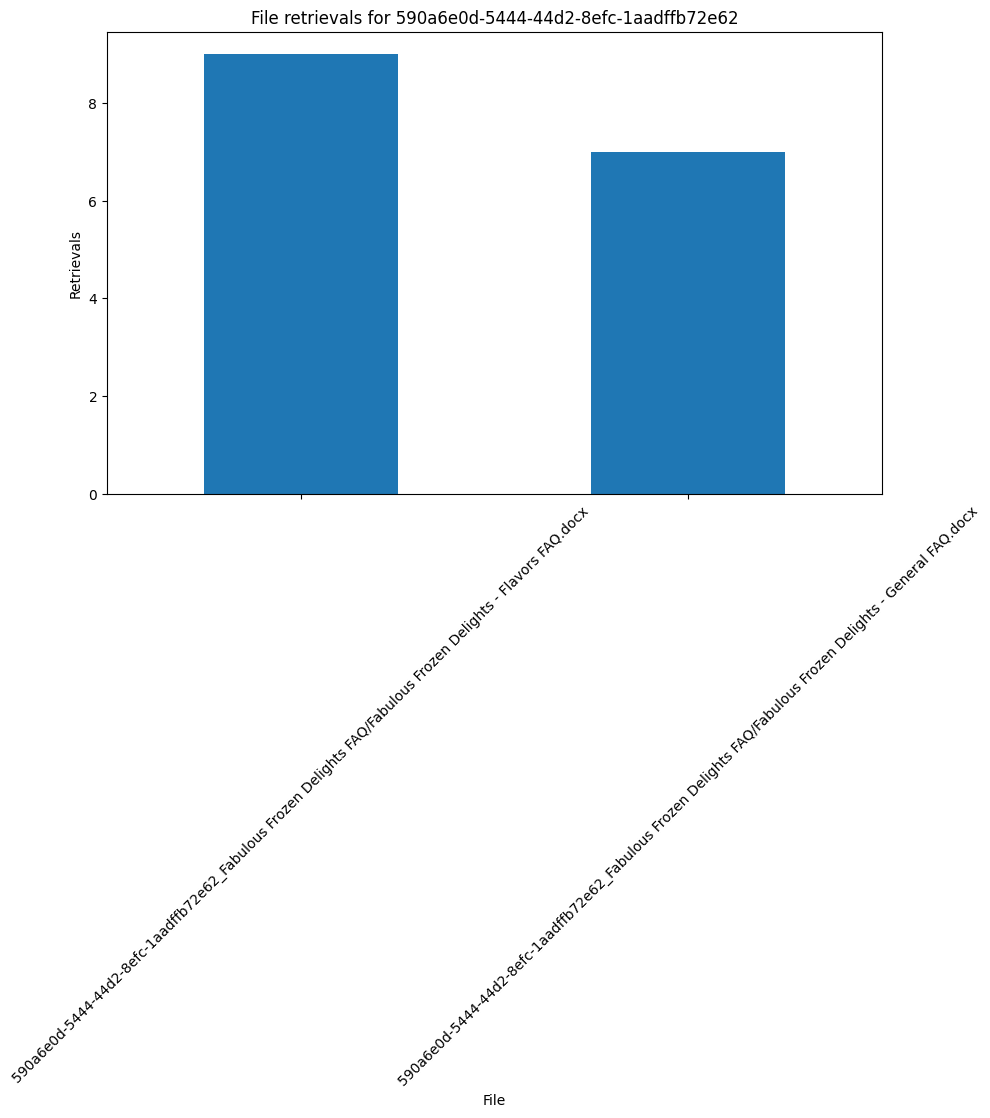

In [110]:
import matplotlib.pyplot as plt
df_retrievals_exploded_grouped = df_retrievals_exploded.groupby(df_retrievals_exploded['files']).size()

plt.figure(figsize=(10, 6))
df_retrievals_exploded_grouped.plot(kind='bar')
plt.xlabel('File')
plt.ylabel('Retrievals')
plt.title(f'File retrievals for {"590a6e0d-5444-44d2-8efc-1aadffb72e62"}')
plt.xticks(rotation=45)
plt.show()

## Basic Auditing - Pipeline and File
Number of searches performed by a user against a pipeline

Number of searches performed by a user against a file

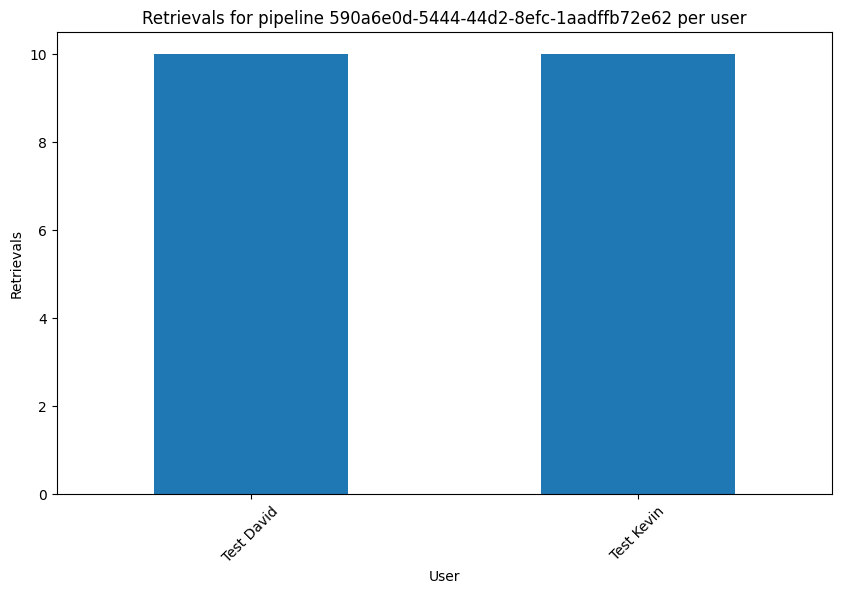

In [111]:
df_retrievals_user = pd.DataFrame(retrievals)
df_retrievals_user_grouped = df_retrievals_user.groupby(df_retrievals_user['requested_by']).size()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
df_retrievals_user_grouped.plot(kind='bar')
plt.xlabel('User')
plt.ylabel('Retrievals')
plt.title(f'Retrievals for pipeline {"590a6e0d-5444-44d2-8efc-1aadffb72e62"} per user')
plt.xticks(rotation=45)
plt.show()

In [112]:
file_retrievals = client.get_retrievals_by_file_id(pipeline_id="590a6e0d-5444-44d2-8efc-1aadffb72e62", file_id="590a6e0d-5444-44d2-8efc-1aadffb72e62_Fabulous Frozen Delights FAQ/Fabulous Frozen Delights - General FAQ.docx")

In [113]:
df_file_retrievals = pd.DataFrame(file_retrievals)
df_file_retrievals = df_file_retrievals.drop(columns=["pipeline_id", "results", "status", "files"])
df_file_retrievals['timestamp'] = df_file_retrievals['timestamp'].apply(calculate_time_differences_unix)
# df_retrievals['modified_time'] = df_retrievals['modified_time'].apply(calculate_time_differences_iso)
display(df_file_retrievals)

,id,requested_by,query,timestamp
0,3ec7ac05-d0fd-41db-98c4-2edc9bf7dc6f,Test David,Can I sample a flavor before making a purchase?,1 hours ago
1,d4ba3ade-b0d5-4ca4-aa05-3e9e515c824b,Test David,Do you offer any discounts or loyalty programs?,1 hours ago
2,26ee9691-bd64-42a9-bea8-81fcb57645c7,Test David,Can I order ice cream cakes or large quantitie...,1 hours ago
3,a24599ca-59ab-4960-833a-53d504f3b9a8,Test Kevin,What are the shop's hours of operation?,1 mins ago
4,4580050b-28d7-4847-ada0-1d436087570c,Test Kevin,Does the ice cream shop offer any loyalty or r...,1 mins ago
5,63aafb61-bb6c-4696-ba19-0724955941db,Test Kevin,Is the ice cream made in-house or sourced from...,1 mins ago
6,d62fece0-8351-4f33-8b42-3591fa95ec92,Test Kevin,Does the shop have any seating or outdoor area...,1 mins ago


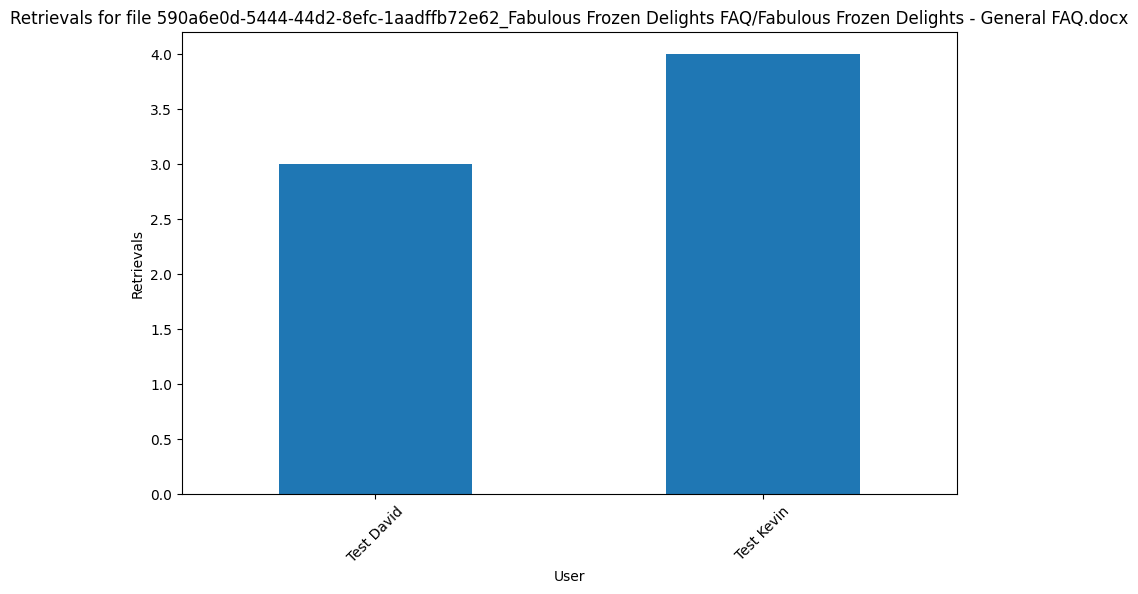

In [114]:
import matplotlib.pyplot as plt
df_file_retrievals_user = df_file_retrievals.groupby(df_file_retrievals['requested_by']).size()

plt.figure(figsize=(10, 6))
df_file_retrievals_user.plot(kind='bar')
plt.xlabel('User')
plt.ylabel('Retrievals')
plt.title(f'Retrievals for file {"590a6e0d-5444-44d2-8efc-1aadffb72e62_Fabulous Frozen Delights FAQ/Fabulous Frozen Delights - General FAQ.docx"}')
plt.xticks(rotation=45)
plt.show()

## Search by user

Searches by user

Files accessed by user

In [98]:
#TBD
# Total searches
# Files accessed by user